In [34]:
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from time import time

In [21]:
adult_test_df = pd.read_csv('datasets/benchmark/adult_clean_test.csv')
adult_train_df = pd.read_csv('datasets/benchmark/adult_clean_train.csv')
titanic_test_df = pd.read_csv('datasets/benchmark/titanic_clean_test.csv')
titanic_train_df = pd.read_csv('datasets/benchmark/titanic_clean_train.csv')
weather_test_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_test.csv')
weather_train_df = pd.read_csv('datasets/benchmark/weatherAUS_clean_train.csv')
wine_test_df = pd.read_csv('datasets/benchmark/wine_test.csv')
wine_train_df = pd.read_csv('datasets/benchmark/wine_train.csv')

In [22]:
def extract_X_y(df, col_y):
    X = df.drop(col_y, axis=1)
    y = df[col_y]
    return X, y

In [87]:
adult_test_X, adult_test_y = extract_X_y(adult_test_df, 'income_>50k')
adult_train_X, adult_train_y = extract_X_y(adult_train_df, 'income_>50k')

titanic_test_X, titanic_test_y = extract_X_y(titanic_test_df, 'Survived')
titanic_train_X, titanic_train_y = extract_X_y(titanic_train_df, 'Survived')

weather_test_X, weather_test_y = extract_X_y(weather_test_df, 'RainTomorrow')
weather_train_X, weather_train_y = extract_X_y(weather_train_df, 'RainTomorrow')

wine_test_X, wine_test_y = extract_X_y(wine_test_df, 'quality')
wine_train_X, wine_train_y = extract_X_y(wine_train_df, 'quality')

In [25]:
def df_features_to_dicts(df):
    columns = df.columns
    dicts = []
   
    for index, row in df.iterrows():
        feature_dict = {}
        for col in columns:
            feature_dict[col] = row[col]
        dicts.append(feature_dict)
    return dicts

In [76]:
adult_test_dict_X = df_features_to_dicts(adult_test_X)
adult_train_dict_X = df_features_to_dicts(adult_train_X)

titanic_test_dict_X = df_features_to_dicts(titanic_test_X)
titanic_train_dict_X = df_features_to_dicts(titanic_train_X)

weather_test_dict_X = df_features_to_dicts(weather_test_X)
weather_train_dict_X = df_features_to_dicts(weather_train_X)

wine_test_dict_X = df_features_to_dicts(wine_test_X)
wine_train_dict_X = df_features_to_dicts(wine_train_X)

In [85]:
titanic_train_X.shape

(1047, 20)

In [86]:
titanic_train_y.shape

(1279,)

In [84]:
len(titanic_train_dict_X)

1047

In [35]:
def compute_score(model, test_X, test_y):
    pred = model.predict(test_X)
    acc = accuracy_score(pred, test_y)
    f1 = f1_score(pred, test_y)
    conf = confusion_matrix(pred, test_y)

    return acc, f1, conf

In [79]:
def fit_compute_score(model, train_X, train_y, test_X, test_y):
    t0 = time()
    model.fit(train_X, train_y)
    duration = time() - t0
    train_acc, train_f1, train_conf = compute_score(model, train_X, train_y)
    test_acc, test_f1, test_conf = compute_score(model, test_X, test_y)
    print("duration", duration)
    print("train accuracy", train_acc)
    print("train f1", train_f1)
    print("train tn, fp, fn, tp", train_conf.ravel()) 
    print("test accuracy", test_acc)
    print("test f1", test_f1)
    print("test tn, fp, fn, tp", test_conf.ravel())
    print()
    
    return train_acc, train_f1, train_conf, test_acc, test_f1, test_conf

In [80]:
def compare_feature_hashing(train_X, train_dict_X, train_y, test_X, test_dict_X, test_y):
    clf_ridge_default = RidgeClassifier()
    print('ridge_default')
    ridge_default_train_acc, ridge_default_train_f1, ridge_default_train_conf, \
        ridge_default_test_acc, ridge_default_test_f1, ridge_default_test_conf = \
        fit_compute_score(clf_ridge_default, train_X, train_y, test_X, test_y)

    n_estimators = 1000
    clf_randfor_default = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    print('randfor_default')
    randfor_default_train_acc, randfor_default_train_f1, randfor_default_train_conf, \
        randfor_default_test_acc, randfor_default_test_f1, randfor_default_test_conf = \
        fit_compute_score(clf_randfor_default, train_X, train_y, test_X, test_y)

    ridge_train_acc = []
    ridge_train_f1 = []
    ridge_train_conf = []
    ridge_test_acc = []
    ridge_test_f1 = []
    ridge_test_conf = []
    randfor_train_acc = []
    randfor_train_f1 = []
    randfor_train_conf = []
    randfor_test_acc = []
    randfor_test_f1 = []
    randfor_test_conf = []
    for i in range(2, 11, 2):
        percent = 0.1*i
        n_features = math.ceil(train_X.shape[1]*percent)
        print("hasher percent", percent, "n_features", n_features)
        print()
        hasher = FeatureHasher(n_features=n_features)
        train_X_hash = hasher.fit_transform(train_dict_X)
        test_X_hash = hasher.fit_transform(test_dict_X)

        clf_ridge_hash = RidgeClassifier()
        print('ridge_hash')
        ridge_hash_train_acc, ridge_hash_train_f1, ridge_hash_train_conf, \
            ridge_hash_test_acc, ridge_hash_test_f1, ridge_hash_test_conf = \
            fit_compute_score(clf_ridge_hash, train_X_hash, train_y, test_X_hash, test_y)
        ridge_train_acc.append(ridge_hash_train_acc)
        ridge_train_f1.append(ridge_hash_train_f1)
        ridge_train_conf.append(ridge_hash_train_conf)
        ridge_test_acc.append(ridge_hash_test_acc)
        ridge_test_f1.append(ridge_hash_test_f1)
        ridge_test_conf.append(ridge_hash_test_conf)

        clf_randfor_hash = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
        print('randfor_hash')
        randfor_hash_train_acc, randfor_hash_train_f1, randfor_hash_train_conf, \
            randfor_hash_test_acc, randfor_hash_test_f1, randfor_hash_test_conf = \
            fit_compute_score(clf_randfor_hash, train_X_hash, train_y, test_X_hash, test_y)
        randfor_train_acc.append(randfor_hash_train_acc)
        randfor_train_f1.append(randfor_hash_train_f1)
        randfor_train_conf.append(randfor_hash_train_conf)
        randfor_test_acc.append(randfor_hash_test_acc)
        randfor_test_f1.append(randfor_hash_test_f1)
        randfor_test_conf.append(randfor_hash_test_conf)
    
    t = np.arange(2, 11, 2)

    fig, ax = plt.subplots(2, 2, figsize=(15,10), tight_layout=True)
    
    ax[0,0].plot(t, ridge_default_train_acc*np.ones(5), label='ridge_default')
    ax[0,0].plot(t, randfor_default_train_acc*np.ones(5), label='randfor_default')
    ax[0,0].plot(t, ridge_train_acc, label='ridge_hashes')
    ax[0,0].plot(t, randfor_train_acc, label='randfor_hashes')
    ax[0,0].set(xlabel='hash %', ylabel='accuracy', title='train')
    ax[0,0].legend()

    ax[0,1].plot(t, ridge_default_test_acc*np.ones(5), label='ridge_default')
    ax[0,1].plot(t, randfor_default_test_acc*np.ones(5), label='randfor_default')
    ax[0,1].plot(t, ridge_test_acc, label='ridge_hashes')
    ax[0,1].plot(t, randfor_test_acc, label='randfor_hashes')
    ax[0,1].set(xlabel='hash %', ylabel='accuracy', title='test')
    ax[0,1].legend()
    
    ax[1,0].plot(t, ridge_default_train_f1*np.ones(5), label='ridge_default')
    ax[1,0].plot(t, randfor_default_train_f1*np.ones(5), label='randfor_default')
    ax[1,0].plot(t, ridge_train_f1, label='ridge_hashes')
    ax[1,0].plot(t, randfor_train_f1, label='randfor_hashes')
    ax[1,0].set(xlabel='hash %', ylabel='f1', title='train')
    ax[1,0].legend()
    
    ax[1,1].plot(t, ridge_default_test_f1*np.ones(5), label='ridge_default')
    ax[1,1].plot(t, randfor_default_test_f1*np.ones(5), label='randfor_default')
    ax[1,1].plot(t, ridge_test_f1, label='ridge_hashes')
    ax[1,1].plot(t, randfor_test_f1, label='randfor_hashes')
    ax[1,1].set(xlabel='hash %', ylabel='f1', title='test')
    ax[1,1].legend()

    plt.show()

ridge_default
duration 0.08799910545349121
train accuracy 0.8433445089959819
train f1 0.6108462076419353
train tn, fp, fn, tp [28148  4476  1645  4804]
test accuracy 0.8356024158050978
test f1 0.6044334975369458
test tn, fp, fn, tp [6936 1180  426 1227]

randfor_default
duration 12.401001453399658
train accuracy 0.9999488137588616
train f1 0.9998922413793103
train tn, fp, fn, tp [29792     1     1  9279]
test accuracy 0.8555635172484389
test f1 0.6771905742393045
test tn, fp, fn, tp [6878  927  484 1480]

hasher percent 0.2 n_features 19

ridge_hash
duration 0.028002262115478516
train accuracy 0.7799503493460958
train f1 0.2235867798446812
train tn, fp, fn, tp [29237  8042   556  1238]
test accuracy 0.7683488586344559
test f1 0.21341675356273898
test tn, fp, fn, tp [7199 2100  163  307]

randfor_hash
duration 56.2839994430542
train accuracy 0.9997952550354464
train f1 0.9995688726018539
train tn, fp, fn, tp [29791     6     2  9274]
test accuracy 0.8214760978605794
test f1 0.6129604971

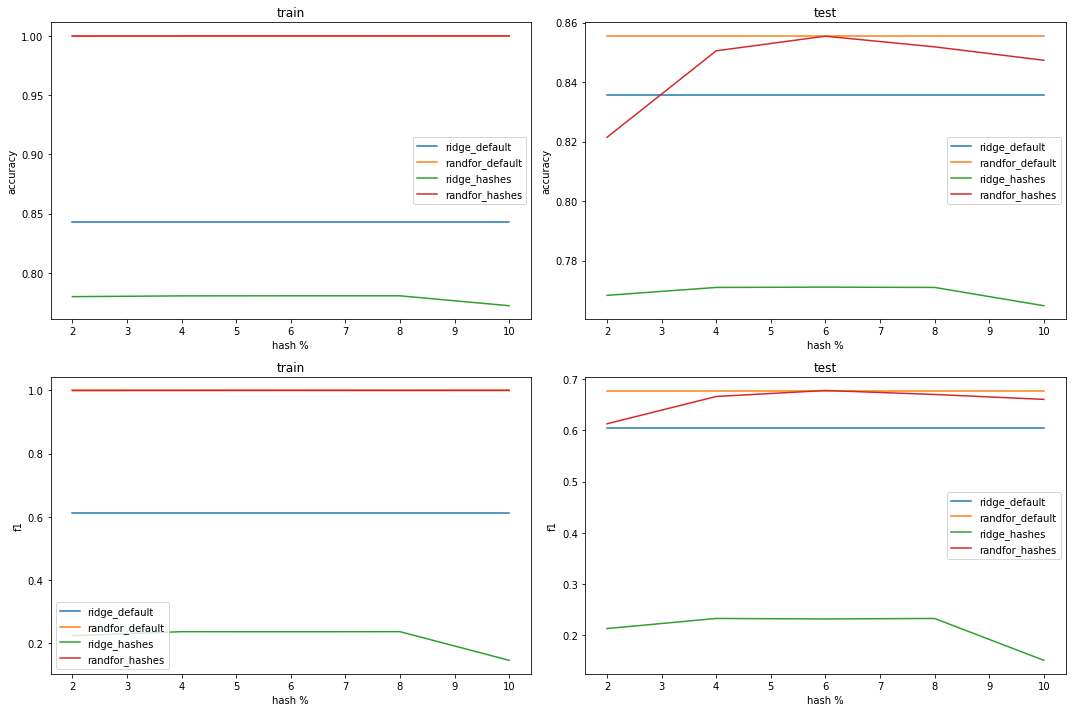

In [121]:
compare_feature_hashing(adult_train_X, adult_train_dict_X, adult_train_y, adult_test_X, adult_test_dict_X, adult_test_y)

ridge_default
duration 0.006024837493896484
train accuracy 0.8538681948424068
train f1 0.7994757536041939
train tn, fp, fn, tp [589  83  70 305]
test accuracy 0.8664122137404581
test f1 0.8223350253807108
test tn, fp, fn, tp [146  25  10  81]

randfor_default
duration 1.6089978218078613
train accuracy 0.9808978032473734
train f1 0.9740932642487047
train tn, fp, fn, tp [651  12   8 376]
test accuracy 0.8320610687022901
test f1 0.7731958762886597
test tn, fp, fn, tp [143  31  13  75]

hasher percent 0.2 n_features 4

ridge_hash
duration 0.004023075103759766
train accuracy 0.7000955109837631
train f1 0.4623287671232877
train tn, fp, fn, tp [598 253  61 135]
test accuracy 0.6183206106870229
test f1 0.3421052631578947
test tn, fp, fn, tp [136  80  20  26]

randfor_hash
duration 1.641922950744629
train accuracy 0.9780324737344794
train f1 0.9700910273081925
train tn, fp, fn, tp [651  15   8 373]
test accuracy 0.7061068702290076
test f1 0.624390243902439
test tn, fp, fn, tp [121  42  35  64]


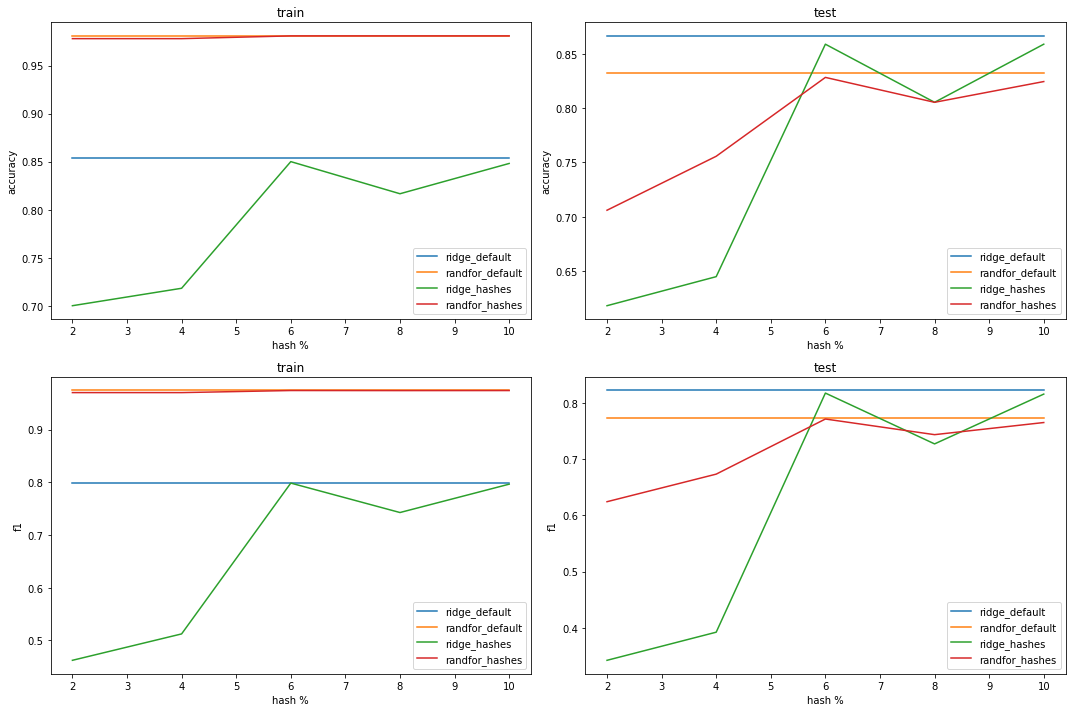

In [88]:
compare_feature_hashing(titanic_train_X, titanic_train_dict_X, titanic_train_y, titanic_test_X, titanic_test_dict_X, titanic_test_y)

In [89]:
compare_feature_hashing(weather_train_X, weather_train_dict_X, weather_train_y, weather_test_X, weather_test_dict_X, weather_test_y)

ridge_default


C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


duration 0.06899833679199219
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_default


C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


duration 4.724021911621094
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

hasher percent 0.2 n_features 6

ridge_hash
duration 0.028000593185424805
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_hash


C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\skl

duration 4.239325761795044
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

hasher percent 0.4 n_features 12

ridge_hash
duration 0.039000749588012695
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_hash


C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\skl

duration 4.281305551528931
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

hasher percent 0.6000000000000001 n_features 18

ridge_hash
duration 0.04699540138244629
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_hash


C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\skl

duration 4.328640699386597
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

hasher percent 0.8 n_features 24

ridge_hash
duration 0.045999765396118164
train accuracy 1.0
train f1 0.0
train tn, fp, fn, tp [97432]
test accuracy 1.0
test f1 0.0
test tn, fp, fn, tp [24358]

randfor_hash


C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\win_1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


KeyboardInterrupt: 

ridge_default
duration 0.006995201110839844
train accuracy 0.7490226739640344
train f1 0.7602688573562361
train tn, fp, fn, tp [449 174 147 509]
test accuracy 0.740625
test f1 0.7446153846153846
test tn, fp, fn, tp [116  51  32 121]

randfor_default
duration 1.7151947021484375
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [596   0   0 683]
test accuracy 0.821875
test f1 0.8288288288288288
test tn, fp, fn, tp [125  34  23 138]

hasher percent 0.2 n_features 3

ridge_hash
duration 0.0019991397857666016
train accuracy 0.6598905394839718
train f1 0.7213324791800129
train tn, fp, fn, tp [281 120 315 563]
test accuracy 0.653125
test f1 0.7101827676240208
test tn, fp, fn, tp [ 73  36  75 136]

randfor_hash
duration 1.8839657306671143
train accuracy 1.0
train f1 1.0
train tn, fp, fn, tp [596   0   0 683]
test accuracy 0.746875
test f1 0.7638483965014577
test tn, fp, fn, tp [108  41  40 131]

hasher percent 0.4 n_features 5

ridge_hash
duration 0.003000020980834961
train accuracy 0.71853

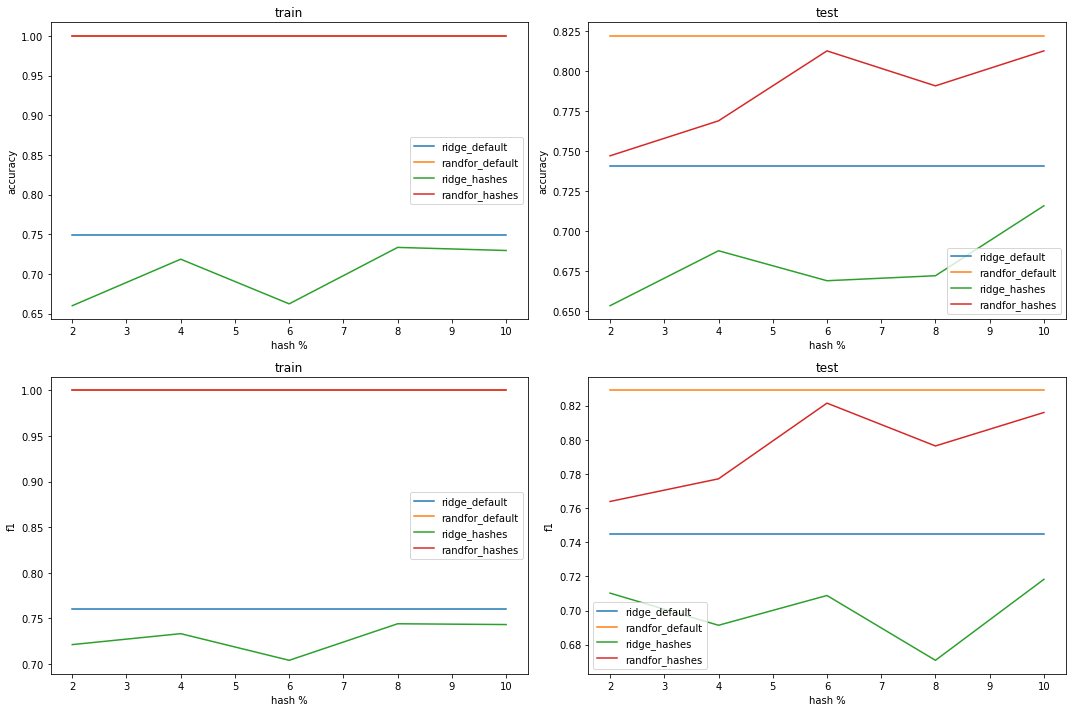

In [97]:
compare_feature_hashing(wine_train_X, wine_train_dict_X, wine_train_y, wine_test_X, wine_test_dict_X, wine_test_y)